# Process
### 1. We will explore the columns of the Boston datasets and come up with four questions to be answered.
### 2. We will perform data wrangling and modeling to answer these three questions.
### 3. We will perform the same analytics on Seattle, and discuss the differences.


### Import Libs

In [2]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from random import random
from datetime import datetime 
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.decomposition import PCA

Populating the interactive namespace from numpy and matplotlib


### Read datasets

In [3]:
# Boston
Boston_Calendar_df = pd.read_csv('Boston_calendar.csv')
Boston_listings_df = pd.read_csv('Boston_listings.csv')
Boston_reviews_df = pd.read_csv('Boston_reviews.csv')

# Seattle
Seattle_Calendar_df = pd.read_csv('Seattle_calendar.csv')
Seattle_listings_df = pd.read_csv('Seattle_listings.csv')
Seattle_reviews_df = pd.read_csv('Seattle_reviews.csv')

### Data exploration

#### We will look into the fields that might be interesting for e.g. predicting price, likelihood that someone likes the apartment, or how price dependends on the season. We thus will focus on numeric or categorical values, leaving out the text-rich values.

For the calendar dataframe, all the columns are interesting.

In [4]:
print(Boston_Calendar_df.shape)
Boston_Calendar_df.columns

(1308890, 4)


Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [5]:
print(Boston_listings_df.shape)
for i in Boston_listings_df.columns:
    print(i)
    print(Boston_listings_df[i].iloc[1])
    print('\n')

(3585, 95)
id
3075044


listing_url
https://www.airbnb.com/rooms/3075044


scrape_id
20160906204935


last_scraped
2016-09-07


name
Charming room in pet friendly apt


summary
Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly.


space
Small but cozy and quite room with a full size bed. Ample street parking.


description
Charming and quiet room in a second floor 1910 condo building. The room has a full size bed, darkening curtains, window A/C unit. It's quiet because it's in the back of the house. Shared bathroom. Guests can use kitchen, living room. Pet friendly. Small but cozy and quite room with a full size bed. Ample street parking. Apt has one more bedroom (which I use) and large living space and kitchen that you can use.  Possibility to do laundry. Two porches. If I am at home, I am li

I will drop the columns that I will not look into and make a list of the columns that I will. I would like to keep that which might be found useful for my endevour. There are some that might be interesting which we have not inlcuded becuase the average was very skewed, for example, in the binary variable of host_has_profile_pic, all hosts had a pic except for 8.

In [6]:

column_list_listing = ['host_response_time', 'host_location', 'host_response_rate', 'host_acceptance_rate',\
              'host_is_superhost', 'neighbourhood', 'city', 'zipcode', 'latitude', 'longitude','is_location_exact', \
              'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',\
              'price', 'security_deposit', 'cleaning_fee', 'square_feet', 'number_of_reviews', 'review_scores_rating',\
              'review_scores_cleanliness', 'review_scores_accuracy',  'review_scores_checkin', 'review_scores_communication', \
              'review_scores_location', 'review_scores_value']

Boston_listings_df = Boston_listings_df[column_list_listing]
Seattle_listings_df = Seattle_listings_df[column_list_listing]


Looking at the columns of Boston_reviews, our analysis will not need this dataset.


In [7]:
print(Boston_reviews_df.shape)
Boston_reviews_df.columns

(68275, 6)


Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

## Here are the questions I will answer on both the Boston and Seattle dataset:
#### 1. How has price developed over time? How much bigger in average have been the prices of Boston in contrast to Seattle throught 2016 and 2017? What is the difference between the all time high and low in avergae price in Boston and in Seattle and what is the ratio between the deltas?
#### 2. What are the attributes that best explain the price of the households advertized and is it possible to predict the price with the given data?
#### 3. What are the features that best explain the listings dataset for Boston and how are these correlated?
#### 4. What are the attributes that best explain good review rating scores of the households advertized and is it possible to predict the reviews with the given data?

## How has price developed over time?

In [8]:
Boston_Calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


I am interested in price, and I see that there are missing values. I will delete them. I will however not impute them, as I am inrerested in a trend, and the fake imputed values would not add insights. We will not study the reasons behind nan values, it is out of the scope of the question. I will apply the same technique to Seattle.

In [9]:
# We delete rows with nan price values.
# Boston
Boston_Calendar_df = Boston_Calendar_df.dropna(subset=['price'], how='any')

# Seattle
Seattle_Calendar_df = Seattle_Calendar_df.dropna(subset=['price'], how='any')

In [10]:
# We look at the types and how the values look like
print(type(Boston_Calendar_df['date'].iloc[0]), type(Boston_Calendar_df['available'].iloc[0]), type(Boston_Calendar_df['price'].iloc[0]))
print(Boston_Calendar_df['date'].iloc[0], Boston_Calendar_df['available'].iloc[0], Boston_Calendar_df['price'].iloc[0])

<class 'str'> <class 'str'> <class 'str'>
2017-08-22 t $65.00


So we need to convert:
1. price: from str to float
2. date: from str to datetime
3. available: from str to bool (for convinience)

In [11]:
# 1. price: from str to float
# We delete the "$" and the "," from the values. It uses commas to indicate thousands
# Boston
Boston_Calendar_df['price'] = Boston_Calendar_df['price'].apply(lambda row: row.replace('$', ''))
Boston_Calendar_df['price'] = Boston_Calendar_df['price'].apply(lambda row: row.replace(',', ''))

# Now we convert the str to float
Boston_Calendar_df = Boston_Calendar_df.astype({"price": float})

# Seattle
Seattle_Calendar_df['price'] = Seattle_Calendar_df['price'].apply(lambda row: row.replace('$', ''))
Seattle_Calendar_df['price'] = Seattle_Calendar_df['price'].apply(lambda row: row.replace(',', ''))

# Now we convert the str to float
Seattle_Calendar_df = Seattle_Calendar_df.astype({"price": float})

In [12]:
# 2. date: from str to datetime
# REF: https://stackabuse.com/converting-strings-to-datetime-in-python/
# Boston
Boston_Calendar_df['date'] = Boston_Calendar_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

# Seattle
Seattle_Calendar_df['date'] = Seattle_Calendar_df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())


In [13]:
# 3. available: from str to bool (for convinience)
# However, there is only one value for 'available'. So we do not consider this column. Likewise for Seattle, to have equal datasets
Boston_Calendar_df['available'].value_counts()

t    643037
Name: available, dtype: int64

In [14]:
# We take the columns that we need
column_list_calendar = ['listing_id', 'date', 'price']
# Boston
Boston_Calendar_df = Boston_Calendar_df[column_list_calendar]
# Seattle
Seattle_Calendar_df = Seattle_Calendar_df[column_list_calendar]

In [15]:
# Let us check that our conversations have worked
print(type(Boston_Calendar_df['date'].iloc[0]), type(Boston_Calendar_df['price'].iloc[0]))
print(Boston_Calendar_df['date'].iloc[0], Boston_Calendar_df['price'].iloc[0])

<class 'datetime.date'> <class 'numpy.float64'>
2017-08-22 65.0


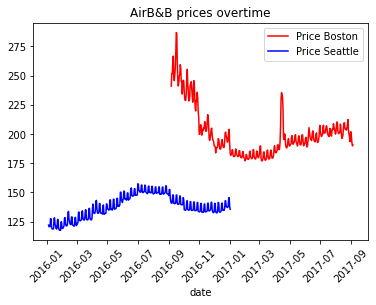

In [17]:
Boston_Calendar_df.groupby('date').price.mean().plot(x='date', y='price', color='red', title='AirB&B prices overtime', legend=True)
Seattle_Calendar_df.groupby('date').price.mean().plot(x='date', y='price', color='blue', legend=True)
plt.xticks(rotation=45)
plt.legend(['Price Boston', 'Price Seattle'])


##### How much bigger in average have been the prices of Boston in contrast to Seattle throught 2016 and 2017?
The answer below indicates a 45% greater in avergae overtime.

In [18]:
Boston_Calendar_df.groupby('date').price.mean().mean() / Seattle_Calendar_df.groupby('date').price.mean().mean()

1.4587570599166912

##### What is the difference between the all time high and low in avergae price in Boston and in Seattle and what is the ratio between the deltas?
The prices in Boston have had a larger delta than in Seattle. Check the data below.

In [19]:
Boston_delta = Boston_Calendar_df.groupby('date').price.mean().max() - Boston_Calendar_df.groupby('date').price.mean().min()
Seattle_delta = Seattle_Calendar_df.groupby('date').price.mean().max() - Seattle_Calendar_df.groupby('date').price.mean().min()


print('Boston delta', Boston_delta)
print('Seattle delta', Seattle_delta)
print('Delta ratio Boston/Seattle', Boston_delta/Seattle_delta)


Boston delta 109.89897486784852
Seattle delta 39.79458699472758
Delta ratio Boston/Seattle 2.7616563750846095


#### Conclusions
Something to note before writing the conclusions is that the data from Boston and Seattle do not overlap in dates 100%, they overlap only by the end of 2016 and begining of 2017. The first an obvious conclusion is that the prices of AirB&Bs in Boston (red) are much greater overtime in average, a 45%. The second conclusion is that the prices for Boston fluctuate more than in Seattle, the deltas are more erratic. The third conclusion is that the prices of Boston have a downward trend, while in Seattle have an upward trend. And the fourth conclusion is that the maximum delta of prices in Boston is 176% higher than in Seattle. 
The downward trend on Boston at the begining might be due to a hype of AirB&B when it was first released in Boston. Then market forces reduced the avergae prices of the households and around halfway on its trendline, the prices start to pick up again in a mild upward trend, like the one Seattle had in the beginning. 
Another interesting feature of the Boston curve to check is the spike that sprouts around April 2017. Doing some googling, I found the event that might have caused the spike, a massive marathon (26k runners): https://en.wikipedia.org/wiki/2017_Boston_Marathon

## 2. What are the attributes that best explain the price of the households advertized and is it possible to predict the price with the given data?


### Data wrangling 

In [20]:
Seattle_listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_time           3295 non-null   object 
 1   host_location                3810 non-null   object 
 2   host_response_rate           3295 non-null   object 
 3   host_acceptance_rate         3045 non-null   object 
 4   host_is_superhost            3816 non-null   object 
 5   neighbourhood                3402 non-null   object 
 6   city                         3818 non-null   object 
 7   zipcode                      3811 non-null   object 
 8   latitude                     3818 non-null   float64
 9   longitude                    3818 non-null   float64
 10  is_location_exact            3818 non-null   object 
 11  property_type                3817 non-null   object 
 12  room_type                    3818 non-null   object 
 13  accommodates      

In [21]:
Boston_listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_time           3114 non-null   object 
 1   host_location                3574 non-null   object 
 2   host_response_rate           3114 non-null   object 
 3   host_acceptance_rate         3114 non-null   object 
 4   host_is_superhost            3585 non-null   object 
 5   neighbourhood                3042 non-null   object 
 6   city                         3583 non-null   object 
 7   zipcode                      3547 non-null   object 
 8   latitude                     3585 non-null   float64
 9   longitude                    3585 non-null   float64
 10  is_location_exact            3585 non-null   object 
 11  property_type                3582 non-null   object 
 12  room_type                    3585 non-null   object 
 13  accommodates      

We are interested in the price, thus, we can drop any row that does not contain a price value

In [22]:
# We delete rows with nan price values.
# Boston
Boston_listings_df = Boston_listings_df.dropna(subset=['price'], how='any')

# Seattle
Seattle_listings_df = Seattle_listings_df.dropna(subset=['price'], how='any')

# In case there are any:
#Drop columns with all NaN values
Boston_listings_df = Boston_listings_df.dropna(how='all', axis=1)

#Drop columns with all NaN values
Seattle_listings_df = Seattle_listings_df.dropna(how='all', axis=1)


In [23]:
for attribute in Boston_listings_df.columns:
    print(attribute, type(Boston_listings_df[attribute].iloc[0]))
    print(Boston_listings_df[attribute].iloc[45])
    

host_response_time <class 'float'>
within an hour
host_location <class 'str'>
Boston, Massachusetts, United States
host_response_rate <class 'float'>
100%
host_acceptance_rate <class 'float'>
83%
host_is_superhost <class 'str'>
f
neighbourhood <class 'str'>
Roslindale
city <class 'str'>
Boston
zipcode <class 'str'>
02131
latitude <class 'numpy.float64'>
42.27636367614069
longitude <class 'numpy.float64'>
-71.13643292507432
is_location_exact <class 'str'>
t
property_type <class 'str'>
House
room_type <class 'str'>
Private room
accommodates <class 'numpy.int64'>
2
bathrooms <class 'numpy.float64'>
2.0
bedrooms <class 'numpy.float64'>
1.0
beds <class 'numpy.float64'>
1.0
bed_type <class 'str'>
Real Bed
price <class 'str'>
$45.00
security_deposit <class 'float'>
nan
cleaning_fee <class 'str'>
nan
square_feet <class 'numpy.float64'>
nan
number_of_reviews <class 'numpy.int64'>
5
review_scores_rating <class 'numpy.float64'>
96.0
review_scores_cleanliness <class 'numpy.float64'>
9.0
review_sco

Some are already in data types I can work with, others however must be converted:

To categories
1. host_response_time: from str to categories
2. host_location: from str to categories
3. bed_type: from str to categories
4. room_type: from str to categories
5. property_type: str to categories
6. city: str to categories
7. zipcode: str to categories
8. neighbourhood: from str to categories
9. host_is_superhost: from str to categories
10. is_location_exact: from str to categories 

To float
1. cleaning_fee: from str to float
2. security_deposit: from str to float
3. price: from str to float 
4. host_response_rate: from str to float
5. host_acceptance_rate: from str to float


##### To categorical

In [24]:
# Function to create dummy variables
def create_dummy_df(df, cat_cols):

    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
        except:
            continue
    return df

In [25]:
# We select the columns that will be converted into dummy variables  
cat_cols = ['host_response_time', 'host_location', 'bed_type', 'room_type', 'property_type', 'city', 'zipcode', 'neighbourhood', 'host_is_superhost', 'is_location_exact']
Boston_listings_df = create_dummy_df(Boston_listings_df, cat_cols)
Seattle_listings_df = create_dummy_df(Seattle_listings_df, cat_cols)


##### To float

1. cleaning_fee: from str to float
2. security_deposit: from str to float
3. price: from str to float 
4. host_response_rate: from str to float
5. host_acceptance_rate: from str to float

In [26]:
# We select the columns that will be converted into floats 
columns_to_float = ['cleaning_fee', 'security_deposit', 'price', 'host_acceptance_rate', 'host_response_rate']

# Boston
# We change the nan float values to string, otherwise .replace would give error handling floats
# REF: https://stackoverflow.com/questions/36000993/numpy-isnan-fails-on-an-array-of-floats-from-pandas-dataframe-apply
def convert_value_into_float(df, columns_to_float):

    for col in columns_to_float:

        df[col] = df[col]\
        .apply(lambda x: x if pd.isnull(np.array([x])) else x.replace('$', ''))

        df[col] = df[col]\
        .apply(lambda x: x if pd.isnull(np.array([x])) else x.replace(',', ''))
        
        df[col] = df[col]\
        .apply(lambda x: x if pd.isnull(np.array([x])) else x.replace('%', ''))

        # Convert them into float
        df[col] = df[col]\
        .apply(lambda x: x if pd.isnull(np.array([x])) else float(x))
        
    return df

Boston_listings_df = convert_value_into_float(Boston_listings_df, columns_to_float)
Seattle_listings_df = convert_value_into_float(Seattle_listings_df, columns_to_float)


In [27]:
# Fill numeric columns with the mean where a nan value exists
def fill_nan_with_mean(df):

    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    
    return df

Boston_listings_df = fill_nan_with_mean(Boston_listings_df)
Seattle_listings_df = fill_nan_with_mean(Seattle_listings_df)


### Data analysis

###### I will check what relationships exist between price and numeric variables. 

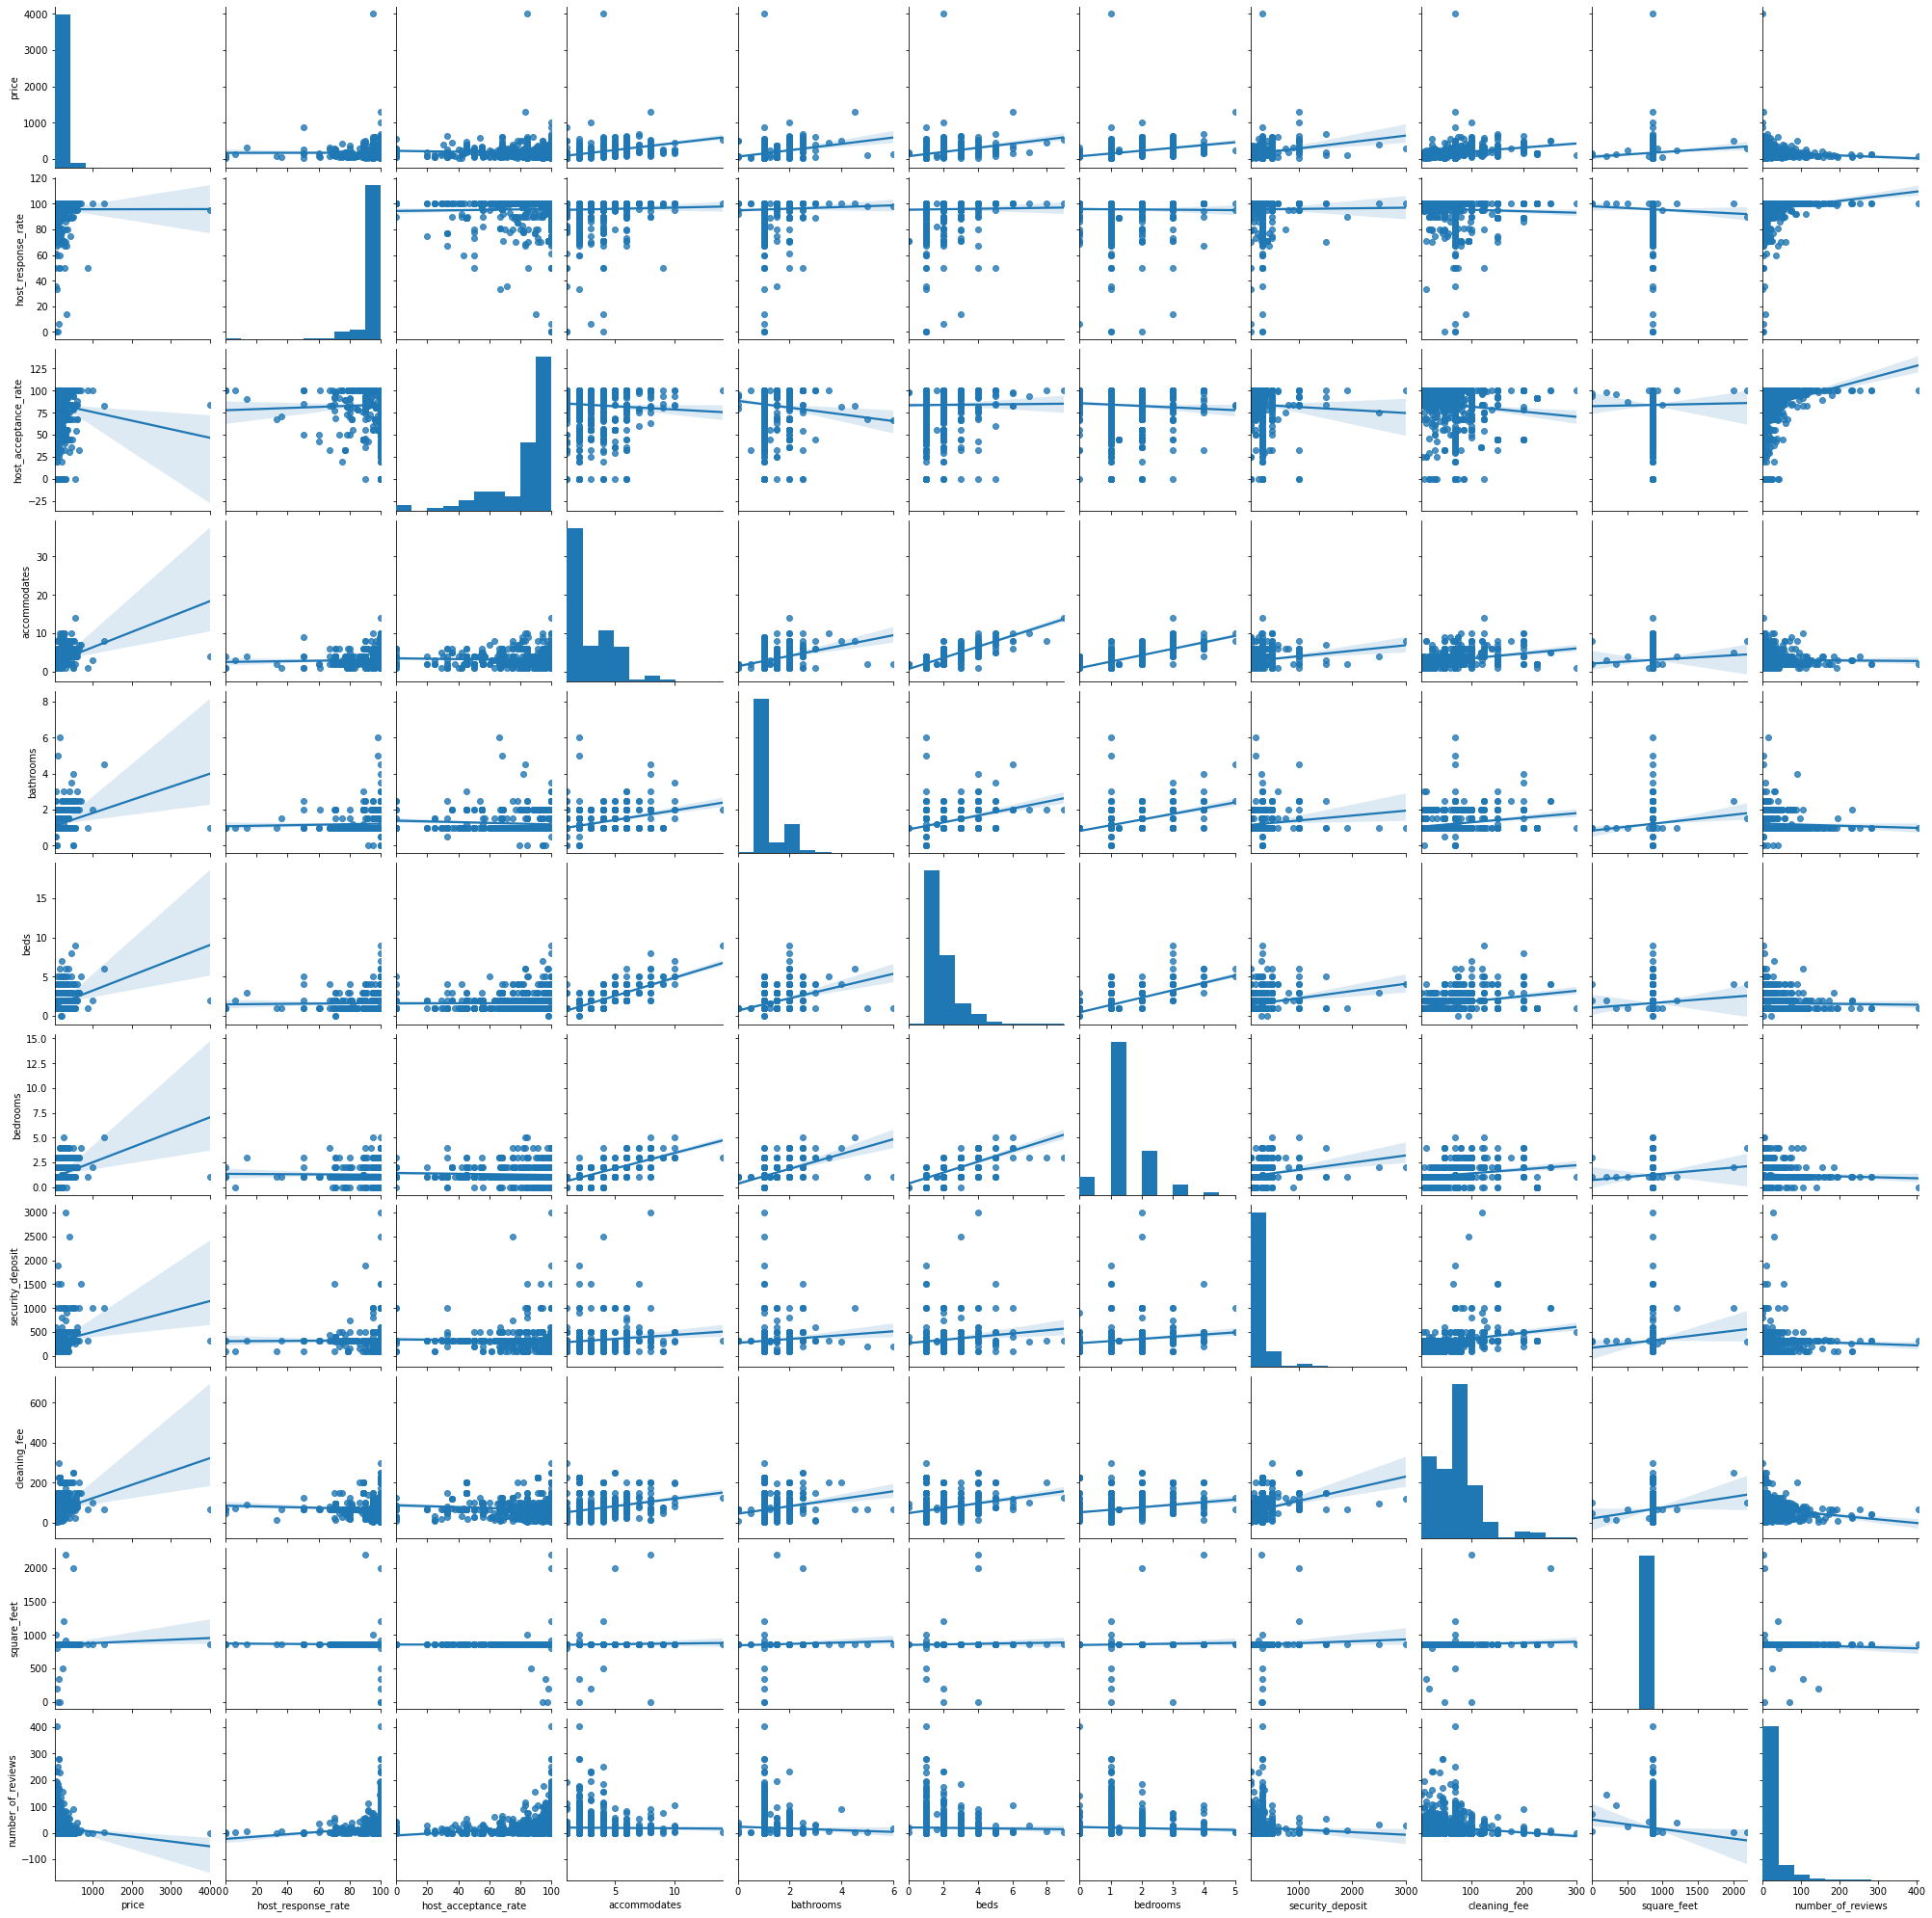

In [28]:
# Boston
g = sns.pairplot(Boston_listings_df.sample(1000, random_state=42), \
                 vars=['price', 'host_response_rate', 'host_acceptance_rate', 'accommodates', 'bathrooms', \
                       'beds', 'bedrooms', 'security_deposit', 'cleaning_fee', 'square_feet', \
                      'number_of_reviews'],kind="reg")


We are only interedted in the first row for price. We see that the response and acceptance rate are not correlated to the price, but as it is logical. However, the number of people that accomodates, the number of rooms like bathrooms, bedrroms, square feet, are correlated. Also the cleaning fee is correlated to price, it makes sense because the larger the place, the more it costs to clean it. Likewise with respect to the security deposit. However, there is no correlation between price and number of reviews. I would have assumed that higher prices, better accomodations and thus more people would be willing to leave a review, but I was wrong.

Let us have a look into other variables related to reviews. 

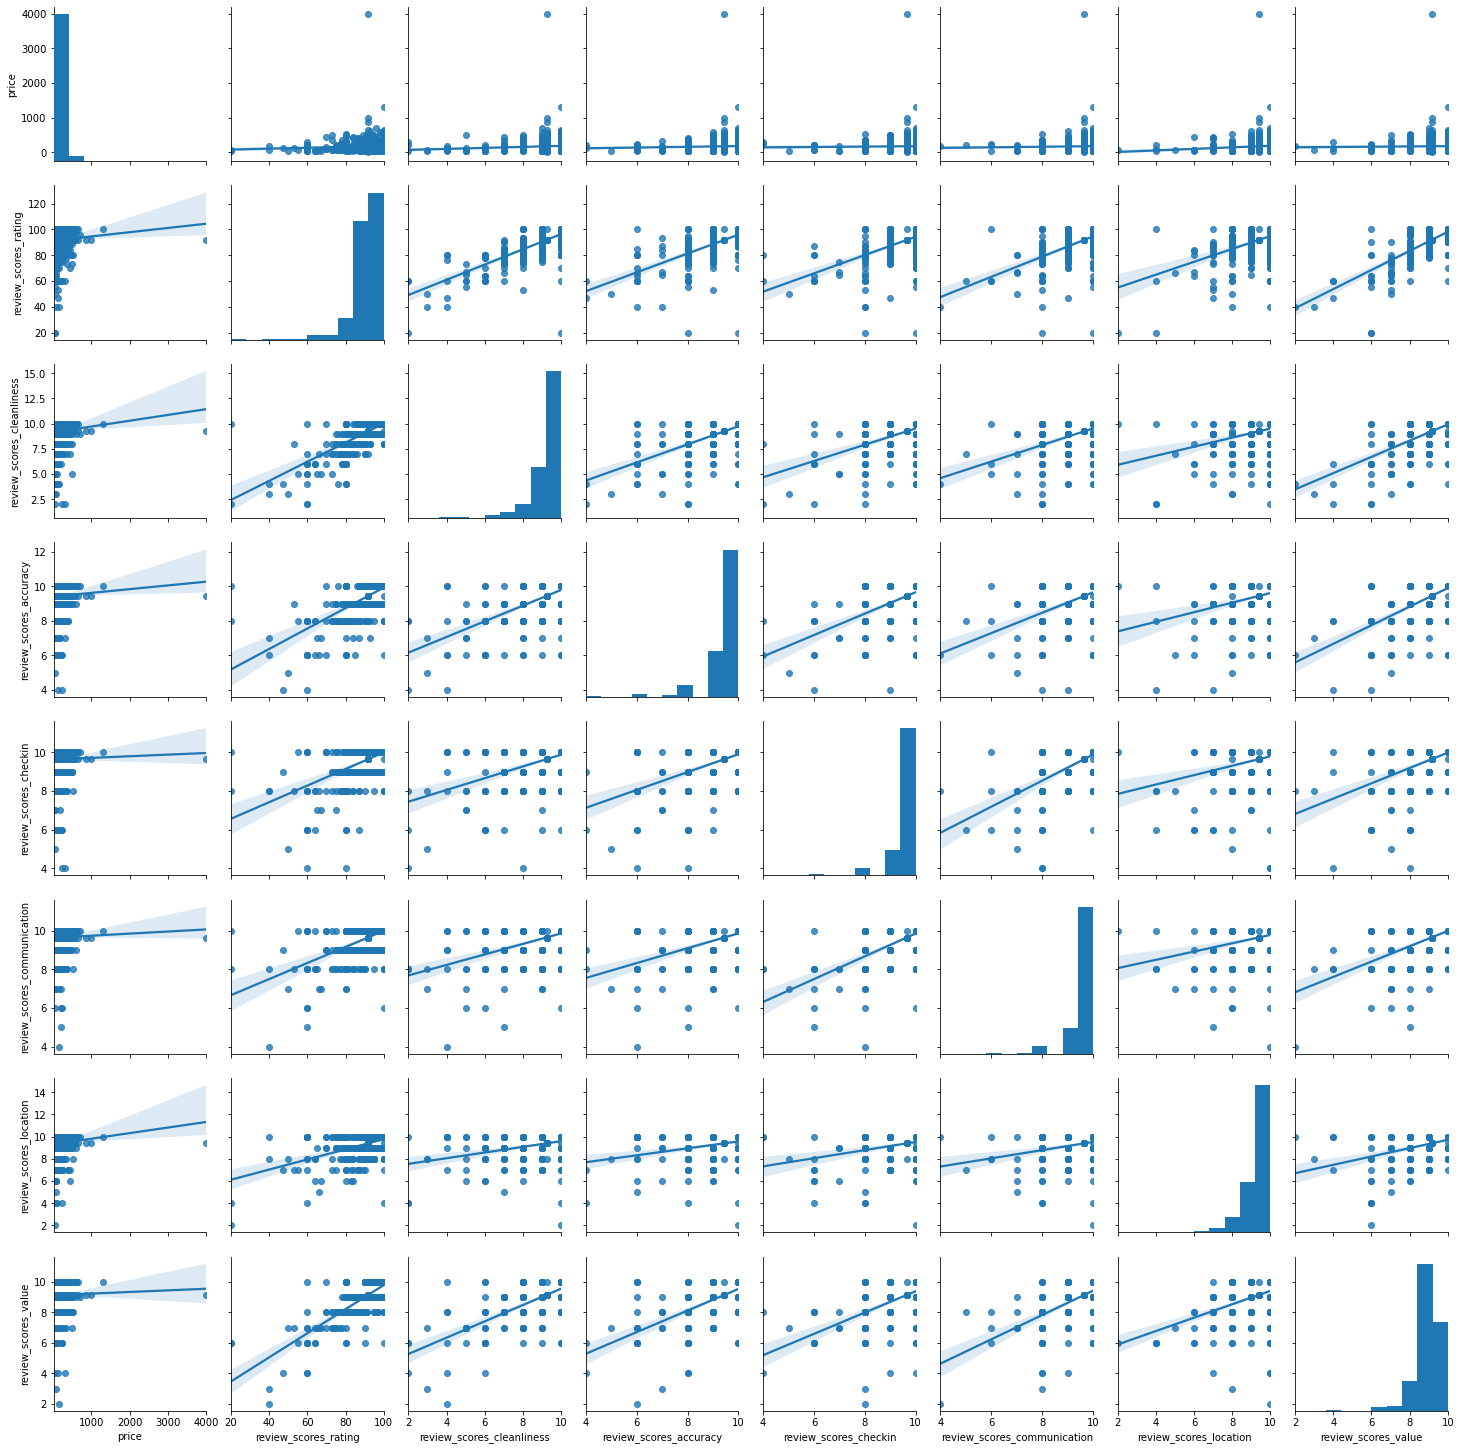

In [29]:
# Boston
g = sns.pairplot(Boston_listings_df.sample(1000, random_state=42), \
                 vars=['price', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_checkin', \
                       'review_scores_communication', 'review_scores_location', 'review_scores_value'] \
                       ,kind="reg")

There is a very slight positive correlation between price and reviews, but nothing to note. This means that the quality/quantity of the apartment in terms of fees, accomodation, etc. which can be represented by the price (as we have seen before), is not an indicator of how happy a customer is. 

Let us see if it is the same conclsion for Seattle:

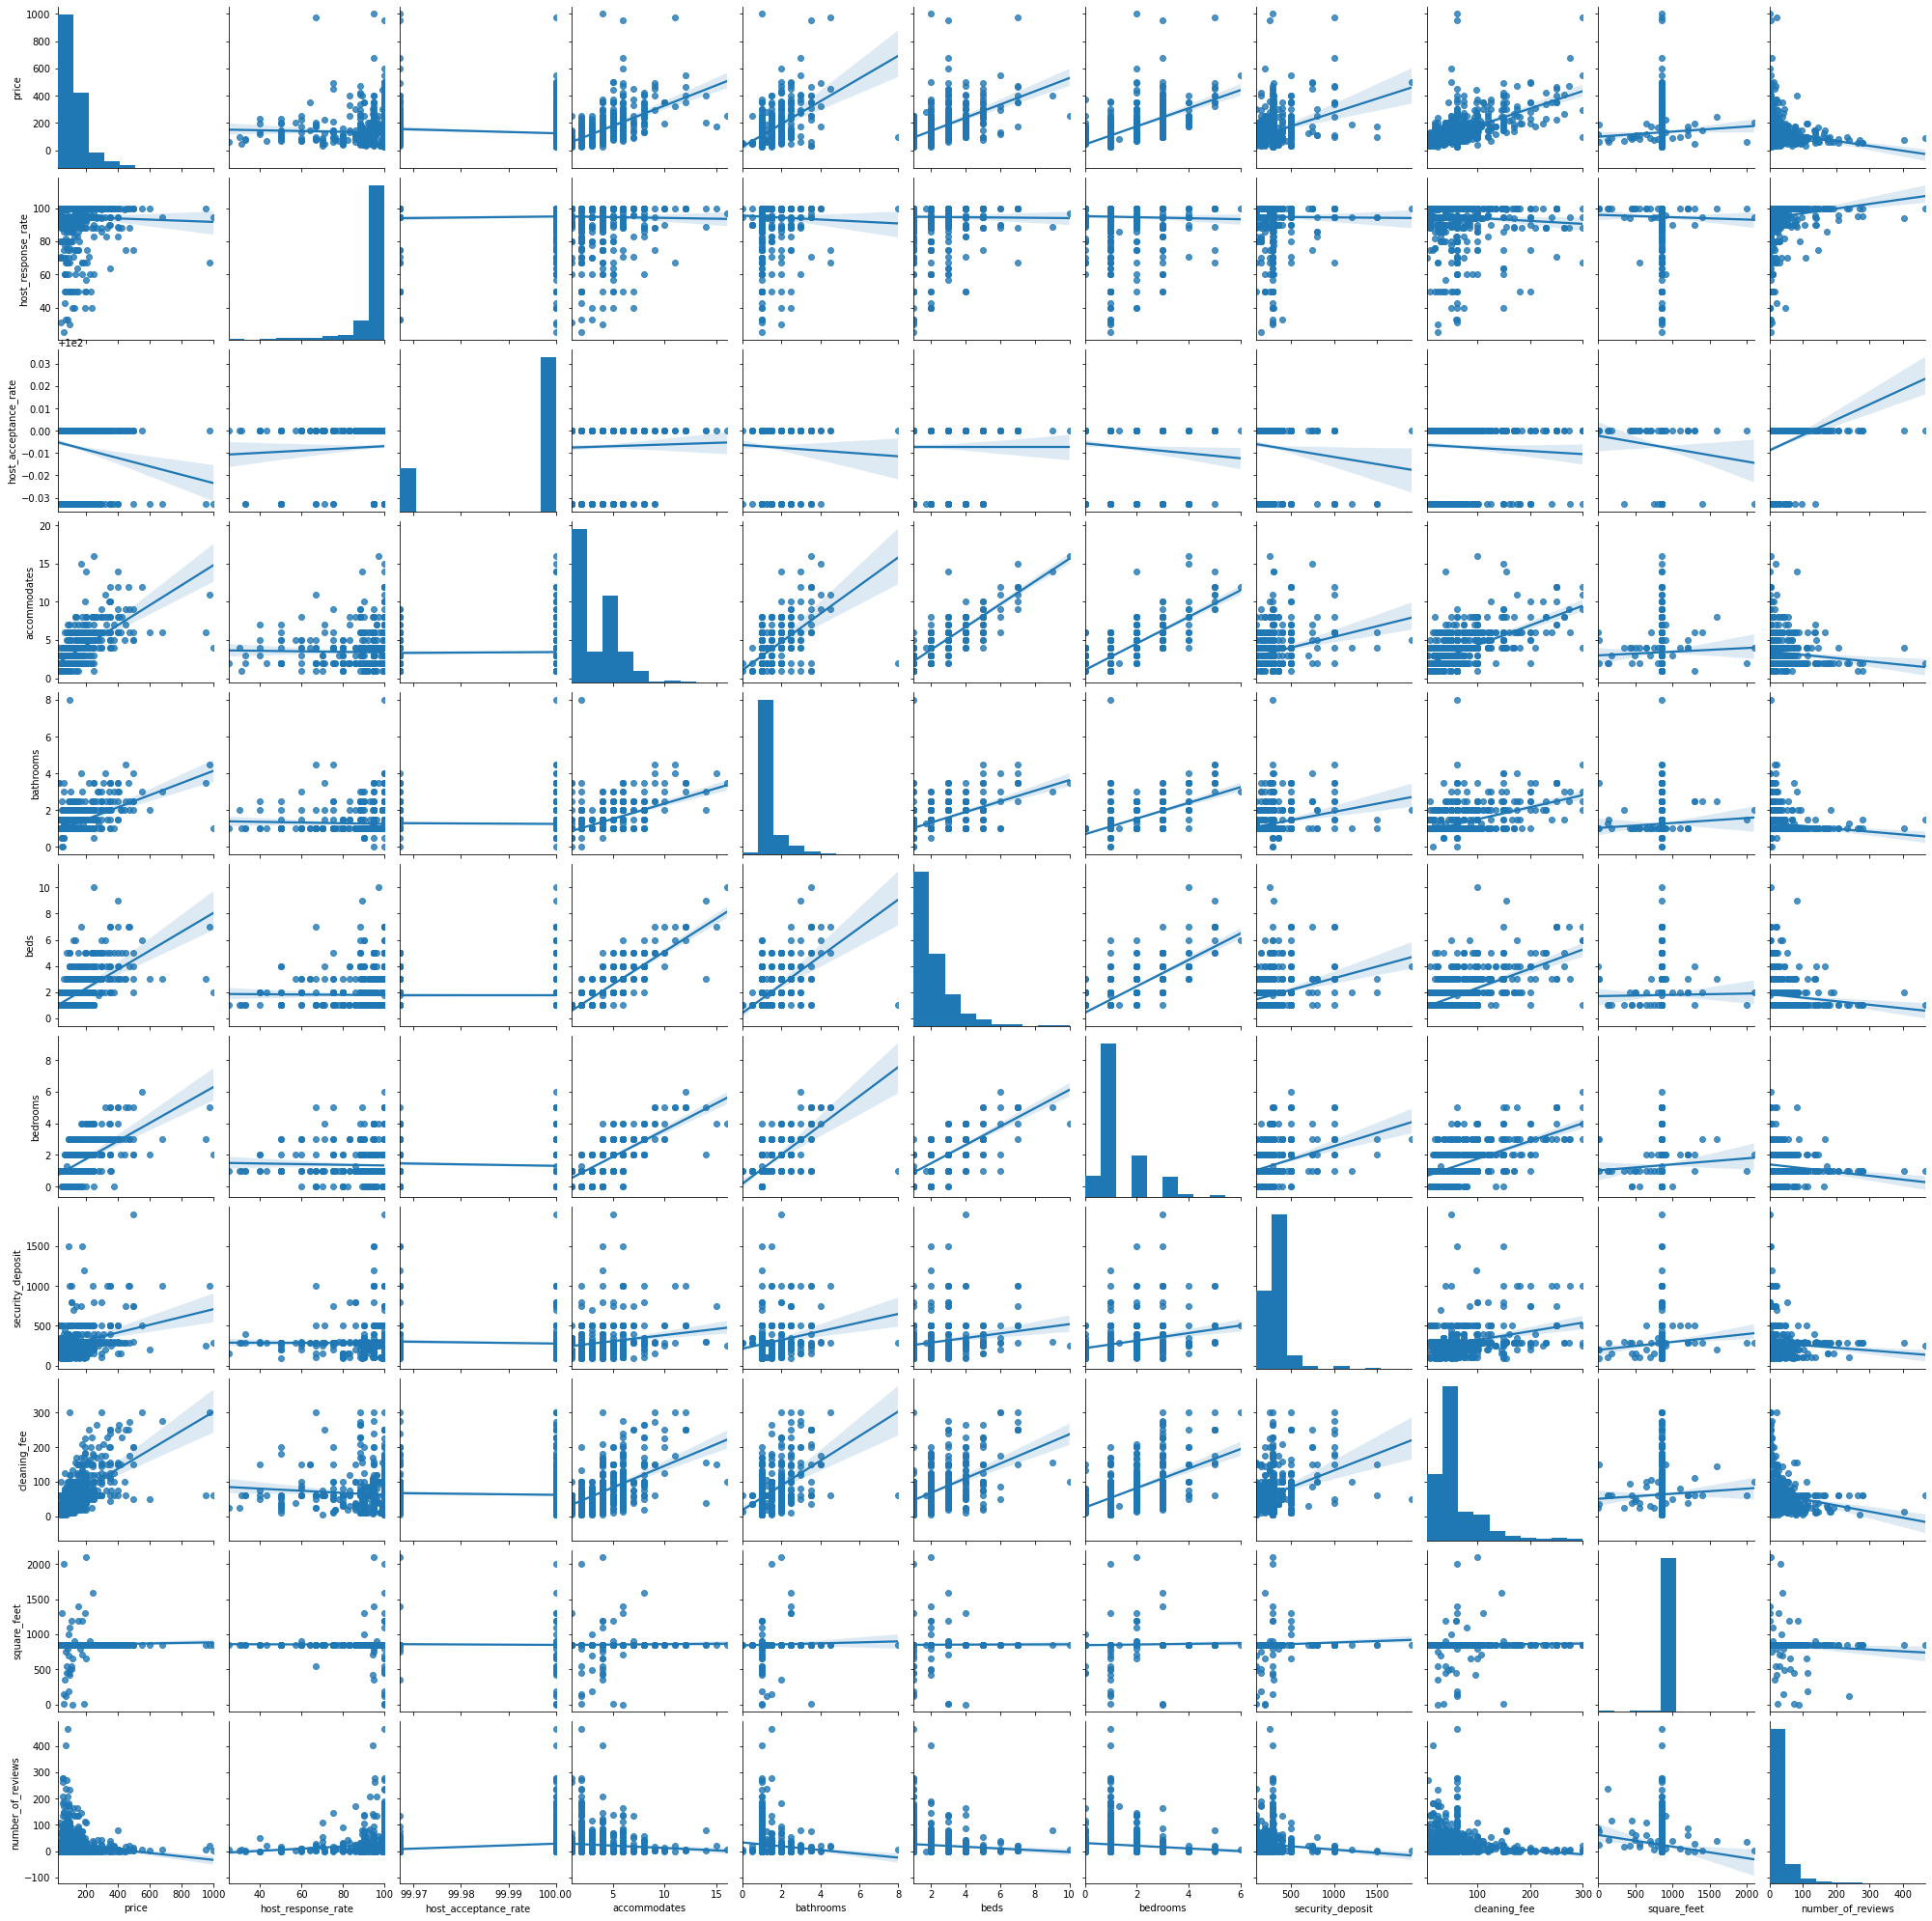

In [30]:
# Seattle
g = sns.pairplot(Seattle_listings_df.sample(1000, random_state=45), \
                 vars=['price', 'host_response_rate', 'host_acceptance_rate', 'accommodates', 'bathrooms', \
                       'beds', 'bedrooms', 'security_deposit', 'cleaning_fee', 'square_feet', \
                      'number_of_reviews'],kind="reg")

They have the same positive correlation as it happened in Boston. 

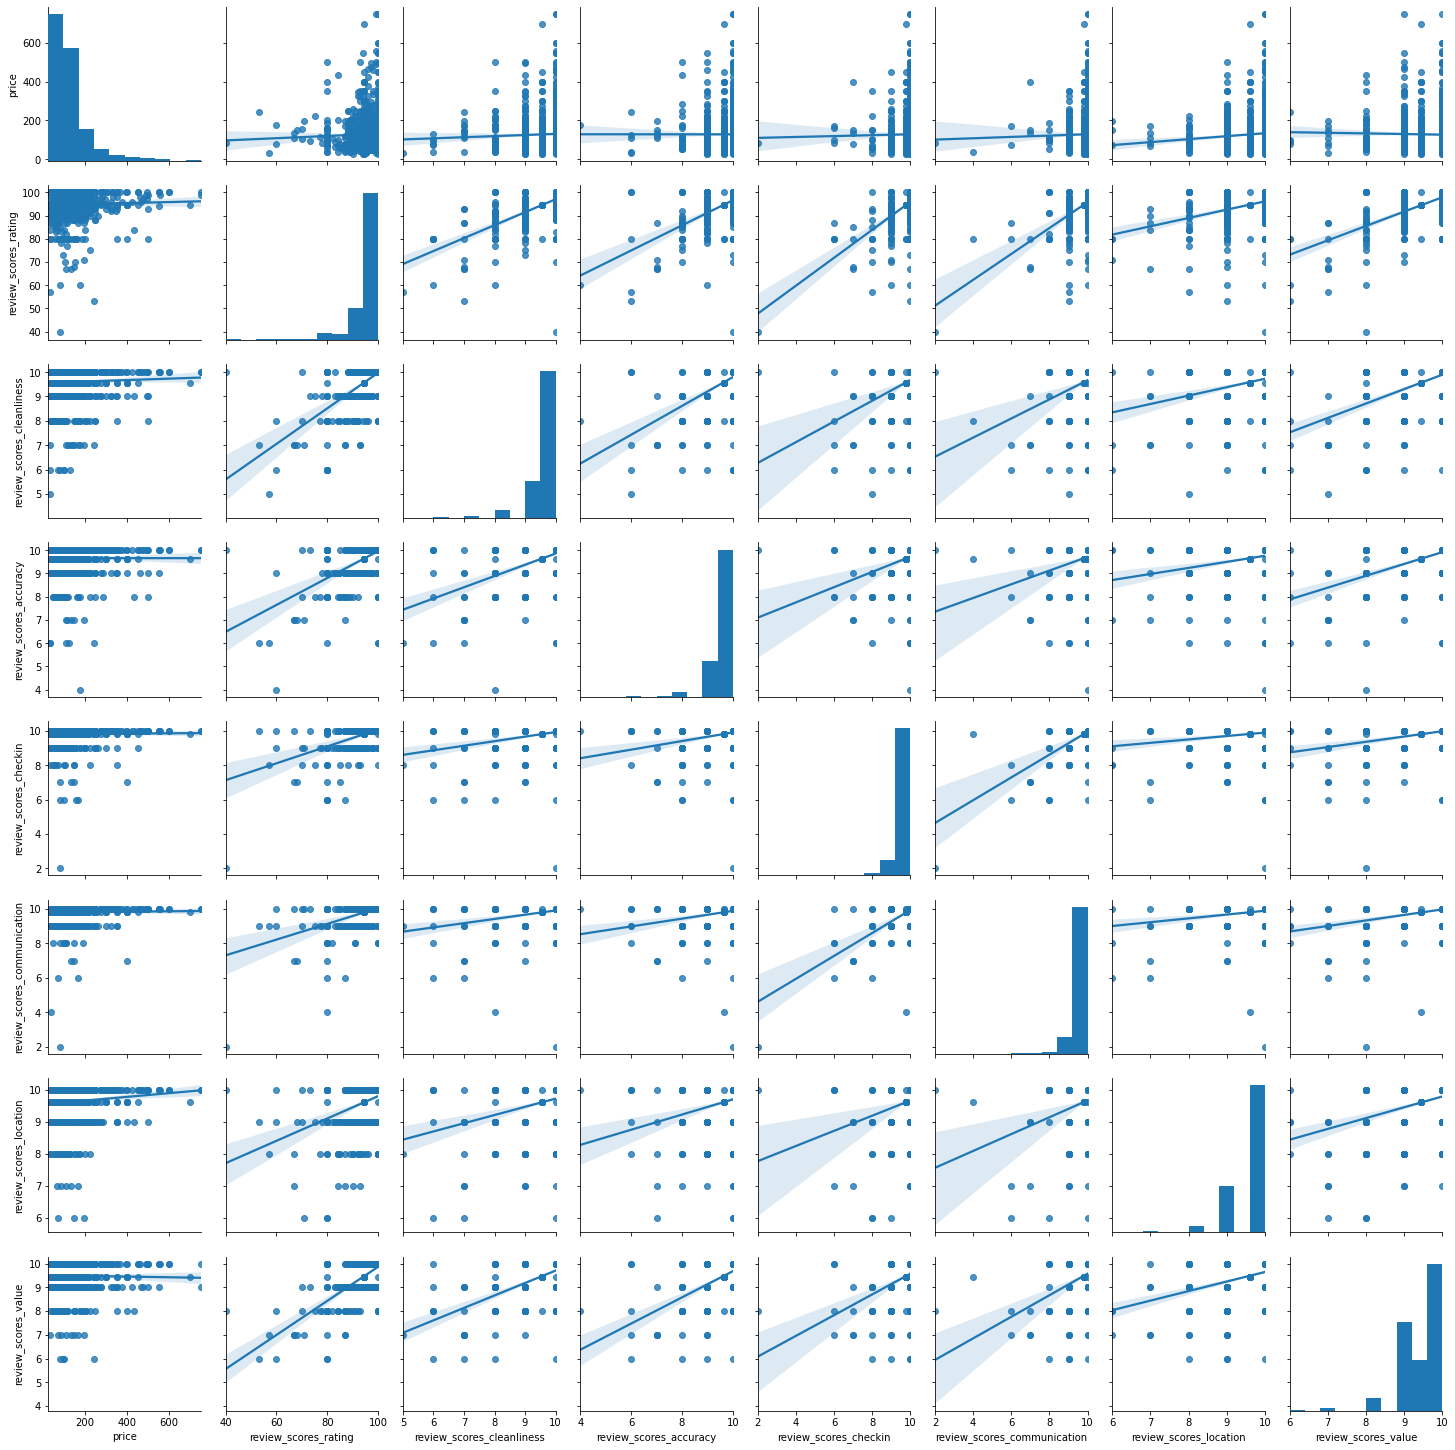

In [31]:
# Seattle
g = sns.pairplot(Seattle_listings_df.sample(1000, random_state=42), \
                 vars=['price', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_checkin', \
                       'review_scores_communication', 'review_scores_location', 'review_scores_value'] \
                       ,kind="reg")

With respect to the second anaylsis looking into the review scores, we conclude the same as we did with Boston.

Thus we can conclude that the attributes that best explain price are the accomodation itself, the number of people that can be accomodated and the size of the apartment (square fit, and number of rooms)

### 3. What are the features that best explain the listings dataset for Boston and how are these correlated?

I will do a PCA analysis to have another perspective to the correlations. This however does not target price directly, it provides a general view of what is positively or negatively correlated. Thus, if price is correlated strongly with a variable, we will observe it in the first principle components as well. 

In [32]:
# We perform scaling
scaler = preprocessing.StandardScaler()
Boston_listings_df_scaled = scaler.fit_transform(Boston_listings_df) # Fit and transform the data
Boston_listings_df_scaled = pd.DataFrame(Boston_listings_df_scaled, index=Boston_listings_df.index, columns=Boston_listings_df.columns) #create a dataframe
Boston_listings_df_scaled.columns = Boston_listings_df_scaled.columns #add column names again

In [33]:
Boston_listings_df

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,...,neighbourhood_Roslindale,neighbourhood_Roxbury,neighbourhood_Somerville,neighbourhood_South Boston,neighbourhood_South End,neighbourhood_Theater District,neighbourhood_West End,neighbourhood_West Roxbury,host_is_superhost_t,is_location_exact_t
0,94.989082,84.173089,42.282619,-71.133068,4,1.5,2.0,3.0,250.0,324.698212,...,1,0,0,0,0,0,0,0,0,1
1,100.000000,100.000000,42.286241,-71.134374,2,1.0,1.0,1.0,65.0,95.000000,...,1,0,0,0,0,0,0,0,0,1
2,100.000000,88.000000,42.292438,-71.135765,2,1.0,1.0,1.0,65.0,324.698212,...,1,0,0,0,0,0,0,0,1,1
3,100.000000,50.000000,42.281106,-71.121021,4,1.0,1.0,2.0,75.0,100.000000,...,0,0,0,0,0,0,0,0,0,0
4,100.000000,100.000000,42.284512,-71.136258,2,1.5,1.0,2.0,79.0,324.698212,...,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,96.000000,100.000000,42.380968,-71.083795,3,1.0,1.0,1.0,69.0,95.000000,...,0,0,1,0,0,0,0,0,0,1
3581,10.000000,83.000000,42.347503,-71.118336,2,1.0,1.0,1.0,150.0,100.000000,...,0,0,0,0,0,0,0,0,0,0
3582,78.000000,50.000000,42.371771,-71.071300,4,1.0,1.0,1.0,198.0,324.698212,...,0,0,0,0,0,0,0,0,0,0
3583,100.000000,96.000000,42.385226,-71.080923,2,1.0,1.0,1.0,65.0,100.000000,...,0,0,1,0,0,0,0,0,0,1


In [35]:
# We create the PCA object 
pca = PCA()
Boston_listings_df_pca = pca.fit_transform(Boston_listings_df_scaled)

In [36]:
len(pca.components_)

326

In [37]:
# We check the sum is 1
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
ratios.sum()

1.0

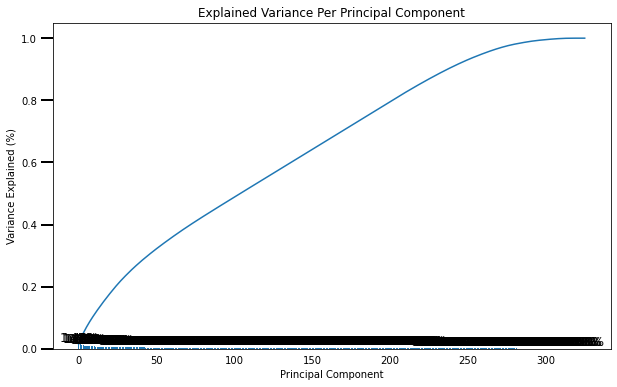

In [38]:
# Function to plot the explained variability
# Ref: Course
def scree_plot(pca):

    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)


In [39]:
vals = pca.explained_variance_ratio_

We can do with the fields that explain at least 85 percent of the variability. It is enough for our endevour and we will need less variables for computation later on if we need to use the principle components as inputs for our models.

In [41]:
cum_variance = 0
index = 0
for ind, val in enumerate(vals):
    
    if cum_variance < 0.85:
        cum_variance += val
        index = ind
    else:
        break

In [42]:
# We print the index of the variable at which the cumulative variance first exceeds 85% of the explained variance
print(index, cum_variance)

219 0.8520127586108187


In [43]:
# Re-apply PCA to the data while selecting for number of components to retain. One more component than the index because the index of
# the previous loop starts at 0, but this object PCA does not
pca_final = PCA(220)
Boston_listings_df_pca = pca_final.fit_transform(Boston_listings_df_scaled)


In [44]:
# We should get around 0.85
ratios = pca_final.explained_variance_ratio_.reshape(len(pca_final.components_), 1)
ratios.sum()

0.8448501469307357

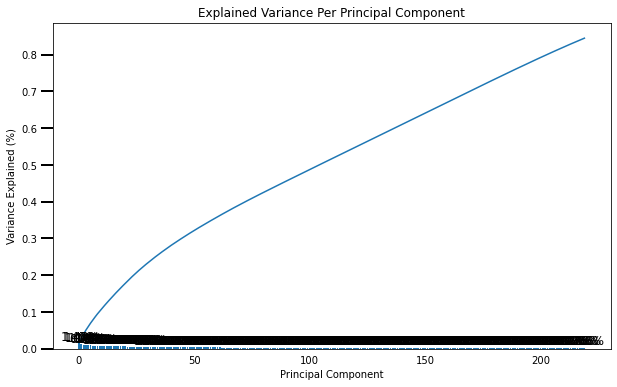

In [45]:
scree_plot(pca_final)

In [46]:
def pca_results(full_dataset, pca, ith_component):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    #dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1).iloc[ith_component]

##### Let us now study the shown correlations

From Udacity: "As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other."

I am going to plot the highest and lowest weights of the first 3 principle components (the ones that explain more variability out of the 219). Each PC will tell us what is positively and negatively correlated within them.

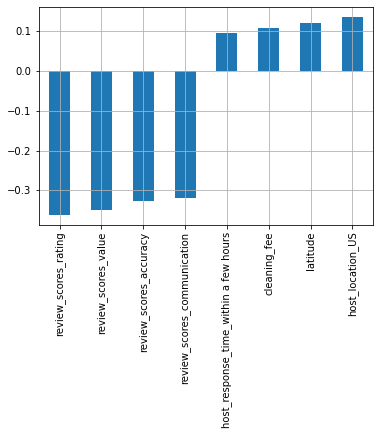

In [47]:
first_PC = pca_results(Boston_listings_df_scaled, pca_final, 0)
first_PC_top_weights = pd.concat([first_PC.sort_values().head(4), first_PC.sort_values().tail(4)])
first_PC_top_weights.plot.bar(grid=True)
plt.show()

#### PC1
##### Positive correlations:

It is logical to think that latitude and host location is correlated. That the cleaning fee increases with latitute and host location might be due to the fact that in those regions with higher latitutde the salaries for workers are higher. And it is also interesting that apparently,the response time is usually of a few hours when the latitutde is higher, but we can logically conclude that it is a mere coincidence, most probably with a larger dataset, this would not be positively correlated.

##### Negative correlations:

It is starightforward to concluce that given a low review of one aspect, the probability that the customer is unhappy with other aspects is also high.

These 2 sets are inversily correlated.


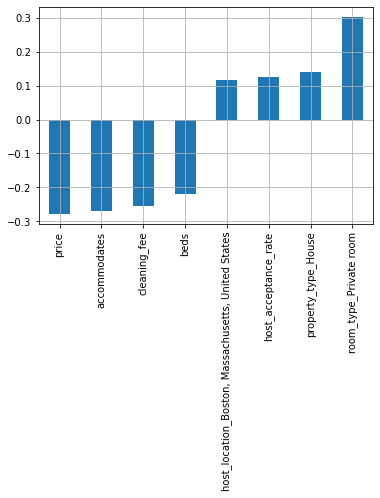

In [48]:
first_PC = pca_results(Boston_listings_df_scaled, pca_final, 1)
first_PC_top_weights = pd.concat([first_PC.sort_values().head(4), first_PC.sort_values().tail(4)])
first_PC_top_weights.plot.bar(grid=True)
plt.show()

#### PC2
##### Positive correlations:

Apparently, there are more private rooms in houses. It makes sense as these are usually larger than other types of accomodatons. The acceptance rate is also correlated and the city Massachusetts.

##### Negative correlations:

This is a very good indicator that the previous anaylsis was on point. The lower the cleaning fee, number of beds and the numbner of people it accomodates, the lower the price. 

These 2 sets are inversily correlated.


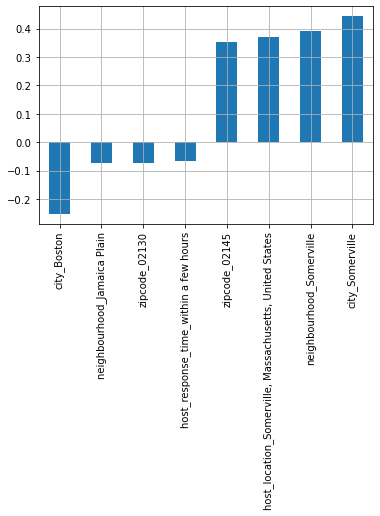

In [49]:
first_PC = pca_results(Boston_listings_df_scaled, pca_final, 2)
first_PC_top_weights = pd.concat([first_PC.sort_values().head(4), first_PC.sort_values().tail(4)])
first_PC_top_weights.plot.bar(grid=True)
plt.show()

#### PC3
##### Positive correlations:

This is not so interesting as many fields from Somerville are positively correlated.

##### Negative correlations:

This is also not so insightful.

These 2 sets are inversily correlated.

### Let us see if we can make a prediction

I will use a linear and a polynomial model on the raw data.

In [50]:
def clean_fit_linear_mod(df, response_col):
    
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

def clean_fit_polynomial_mod(df, response_col):
    
    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]
    
    poly = PolynomialFeatures(degree=2) # Instantiate
    X_poly = poly.fit_transform(X) #Fit

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=43)
    
    regression = LinearRegression()
    poly_model = regression.fit(X_train, y_train)
    
    #Predict using your model
    y_test_preds = poly_model.predict(X_test)
    y_train_preds = poly_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [51]:
# Linear model
# BOSTON
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = \
clean_fit_linear_mod(Boston_listings_df, 'price')
print('Boston test score', test_score, 'train score', train_score)

# SEATTL
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = \
clean_fit_linear_mod(Seattle_listings_df, 'price')
print('Seattle test score', test_score, 'train score', train_score)

Boston test score -6.680342094989378e+27 train score 0.4289838044974963
Seattle test score -8.921724232834625e+27 train score 0.647408942886571


The model does a terrible job predicting the price for both cities.

In [52]:
# Polynomial model
# BOSTON
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = \
clean_fit_polynomial_mod(Boston_listings_df, 'price')
print('Boston test score', test_score, 'train score', train_score)

# SEATTLE
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = \
clean_fit_polynomial_mod(Seattle_listings_df, 'price')
print('Seattle test score', test_score, 'train score', train_score)

Boston test score -4503595.560130922 train score 0.8568133856505753
Seattle test score -530615261353.864 train score 0.9884356355705533


The model does better with the training data but it is terrible in the testing, worst than with the linear model, even though we tried with polynomials of 2 and 3 (3 hangs for too long).

*Conclusion*: We have seen the correlations between price and the rest of the variables, and explained also the different correlations that exist between the variables in the dataset through PCR. We have also tried to predict the price with a linear and a polynomial mode, but not no avail. This means that either there is no causation or we have not enough data. We have also tried to include in the prediction other fields that we had initially excluded like availability and min and max nights, but the model does not improve whatsoever. 

### 3. What are the attributes that best explain good review rating scores of the households advertized and is it possible to predict the reviews with the given data?

We will perform the same data anaylsiss but with review_scores_rating, and we will also try to predict this value. The data wrangling remains the same.

We are interested in the review score. All the review attributes have more or less the same amount of non-null values. Seeing that review_score_accuray has the lowest number of non-null values(by a hair), I will drop the rows that contain a null value in that field. This way, there will be a few edge cases where eg the accuracy or the checkin or the communication are missing while the rating is not. Luckily, for Seattle the same happens.

In [53]:
# We delete rows with nan review_scores_rating values.
# Boston
Boston_listings_df = Boston_listings_df.dropna(subset=['review_scores_rating'], how='any')

# Seattle
Seattle_listings_df = Seattle_listings_df.dropna(subset=['review_scores_rating'], how='any')


##### Analysis

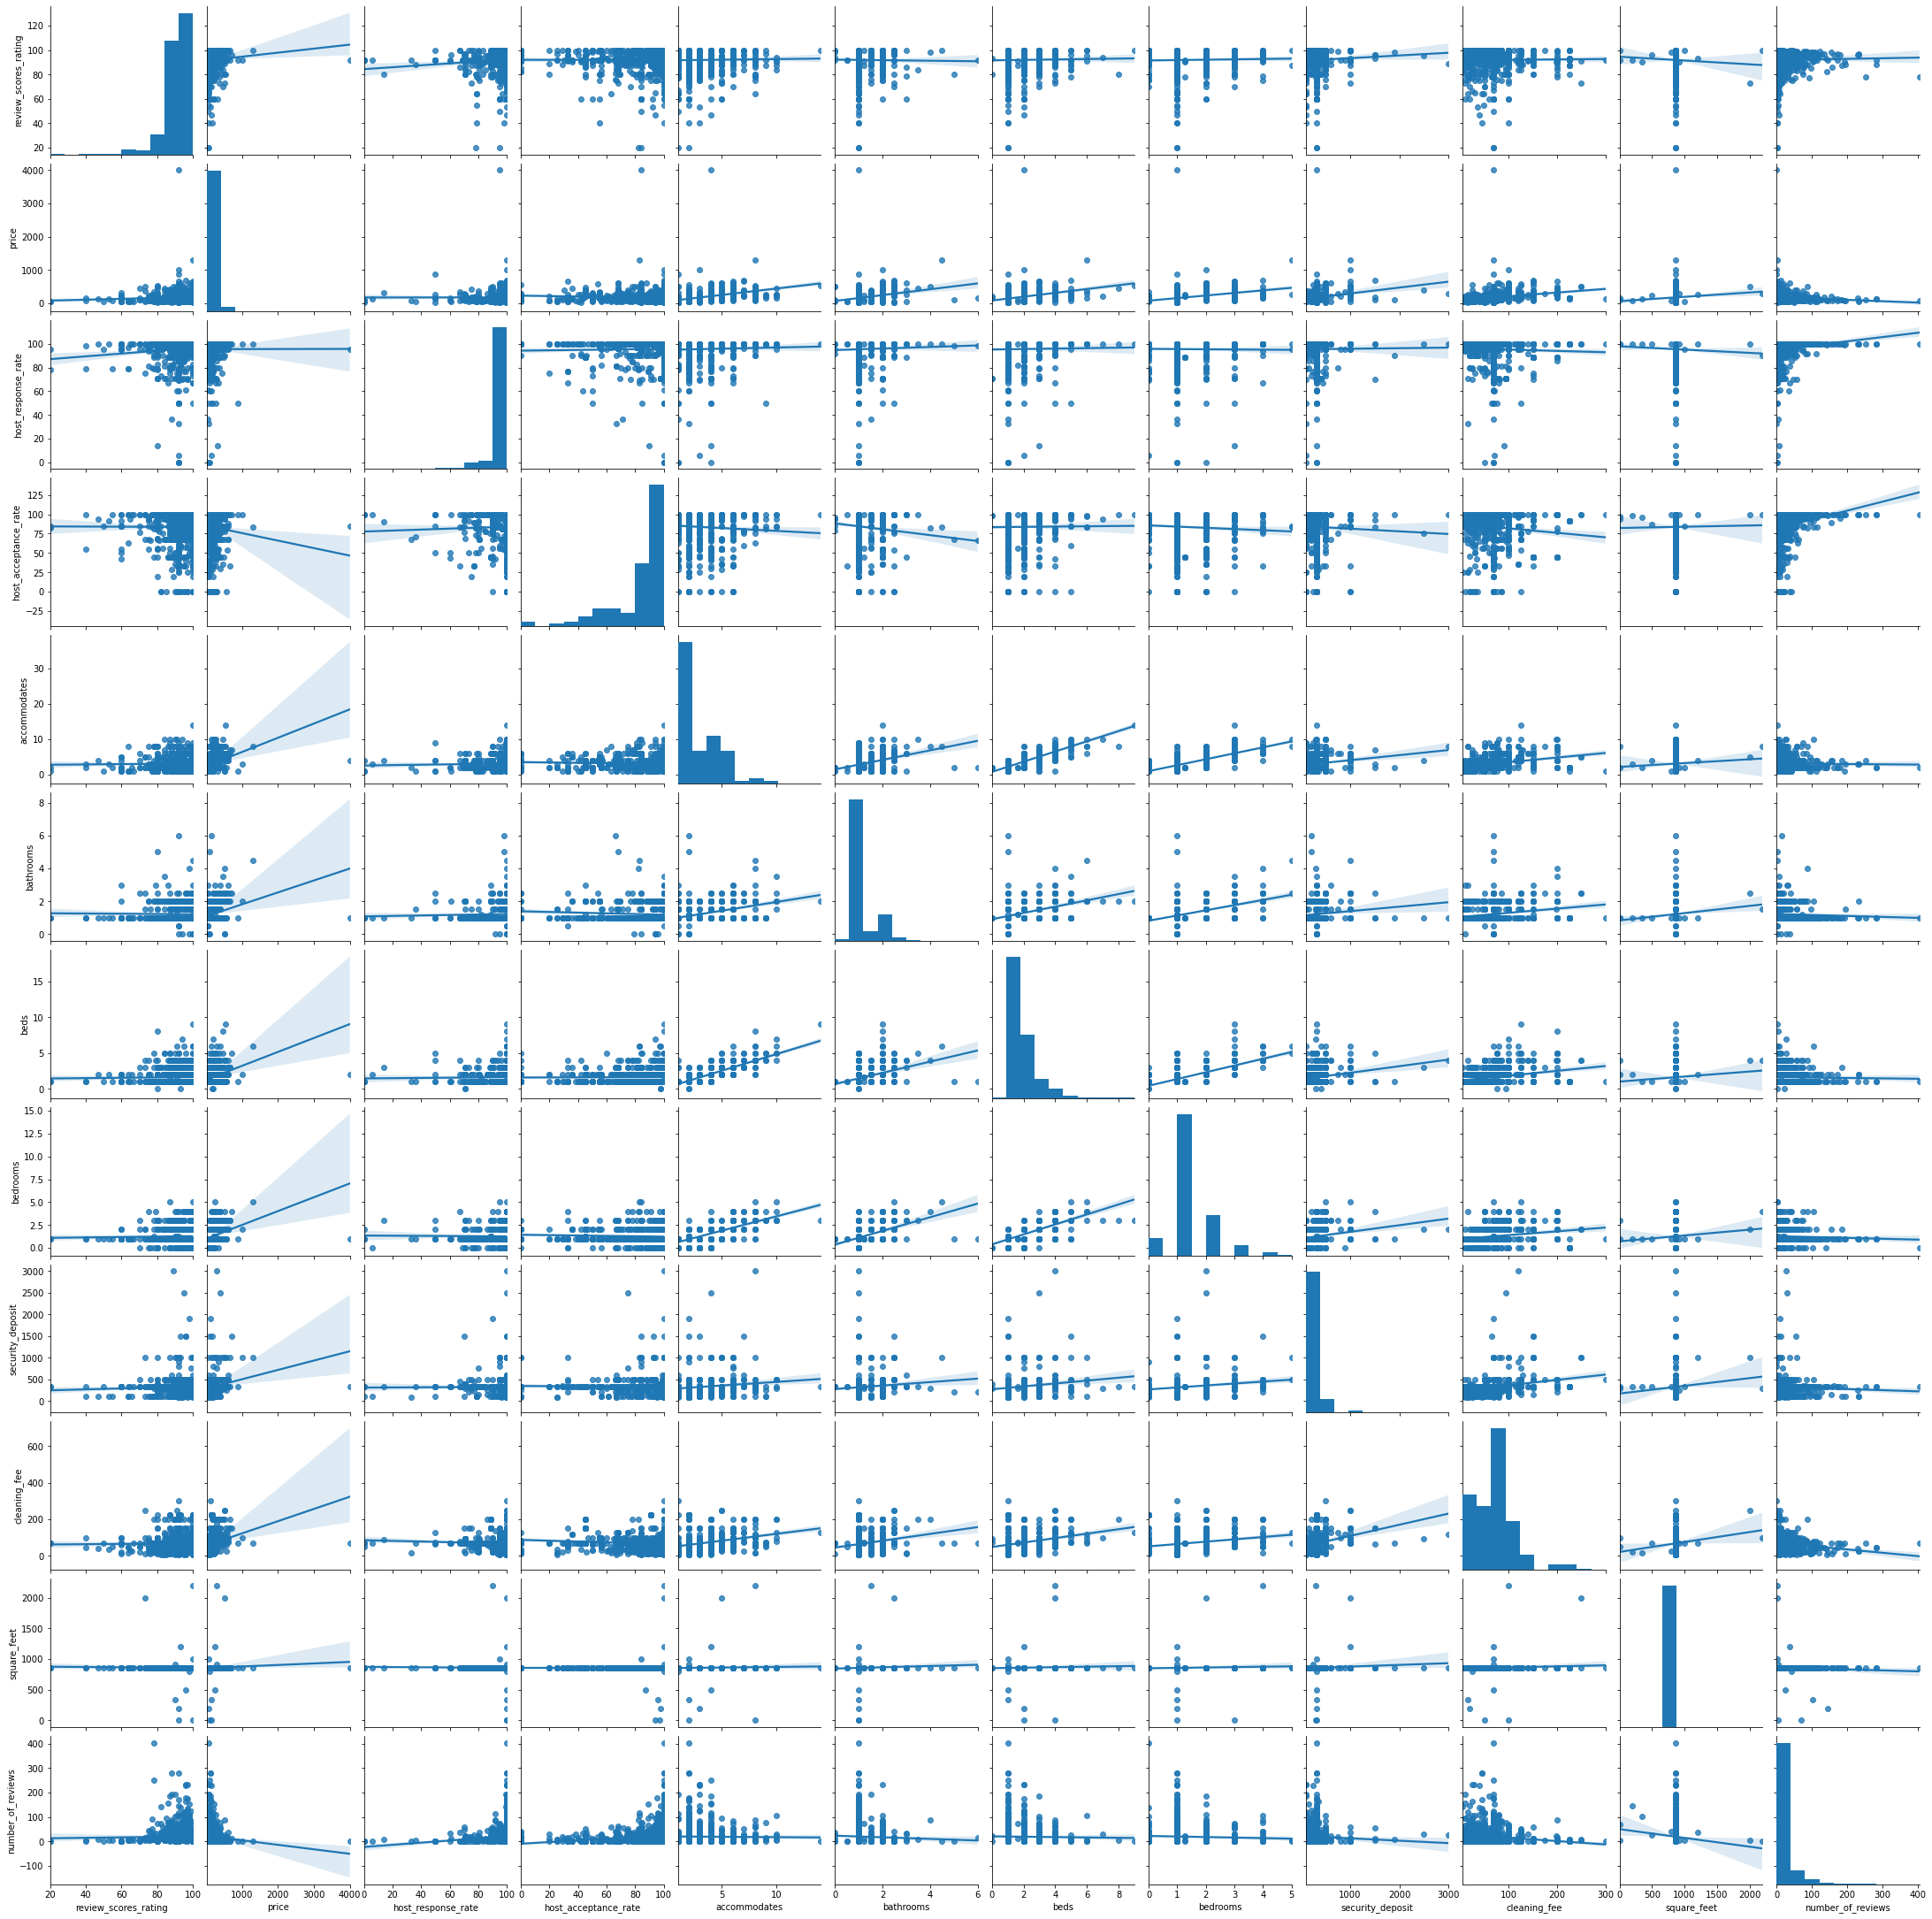

In [54]:
# Boston
g = sns.pairplot(Boston_listings_df.sample(1000, random_state=42), \
                 vars=['review_scores_rating', 'price', 'host_response_rate', 'host_acceptance_rate', 'accommodates', 'bathrooms', \
                       'beds', 'bedrooms', 'security_deposit', 'cleaning_fee', 'square_feet', \
                      'number_of_reviews'],kind="reg")



Looking again only at the first row of figures:
We can see that there is a positive correlation between good ratings and price. We did not see this in the identical study we did for price. There is a slight positive correlation with the response rate and with the security deposit. And on the negative side, there is one with the square feet.

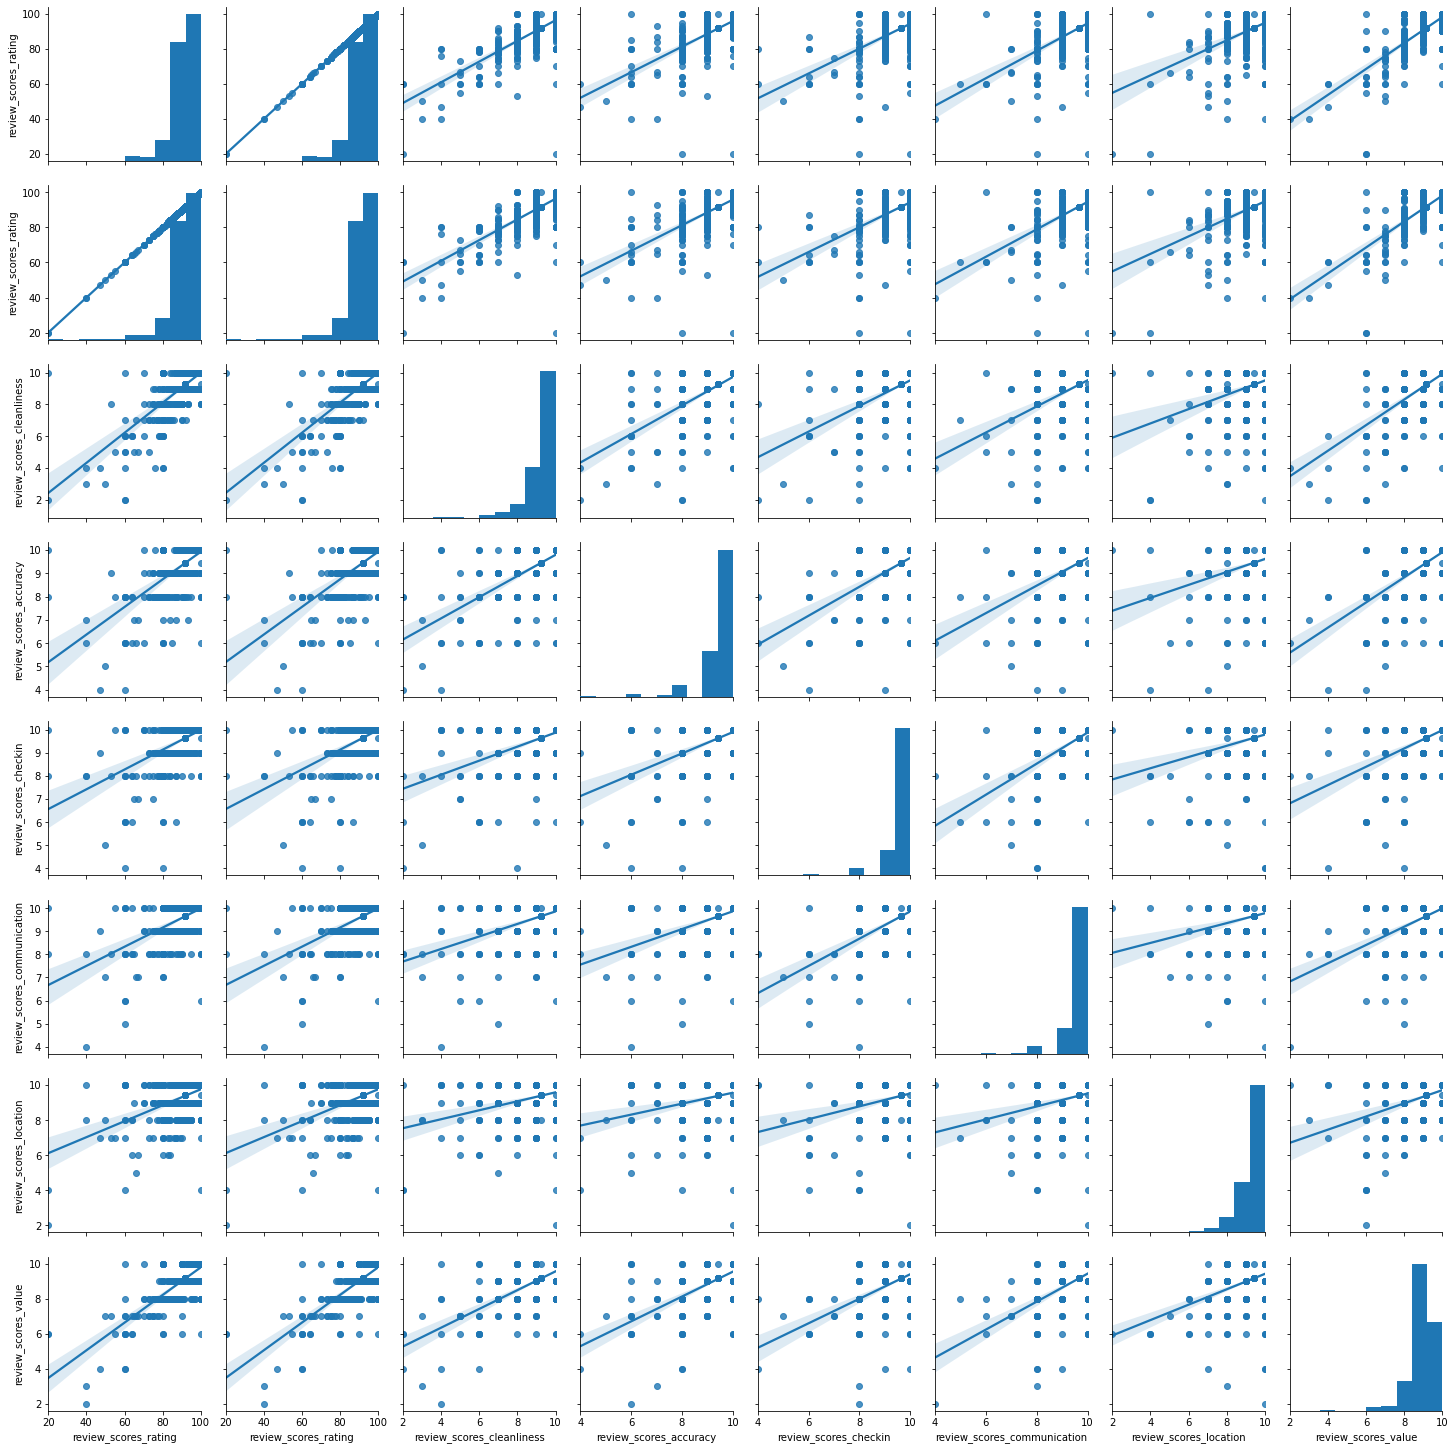

In [55]:
# Boston
g = sns.pairplot(Boston_listings_df.sample(1000, random_state=42), \
                 vars=['review_scores_rating', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_checkin', \
                       'review_scores_communication', 'review_scores_location', 'review_scores_value'] \
                       ,kind="reg")

It was expected to obtain strong positive correlations with the rest of review fields, and indeed, one can observe these relationships in the figures.

We expect to see the same relationships as in Boston as in Seattle, as there was not much difference between them with the previous analysis from the previous question.

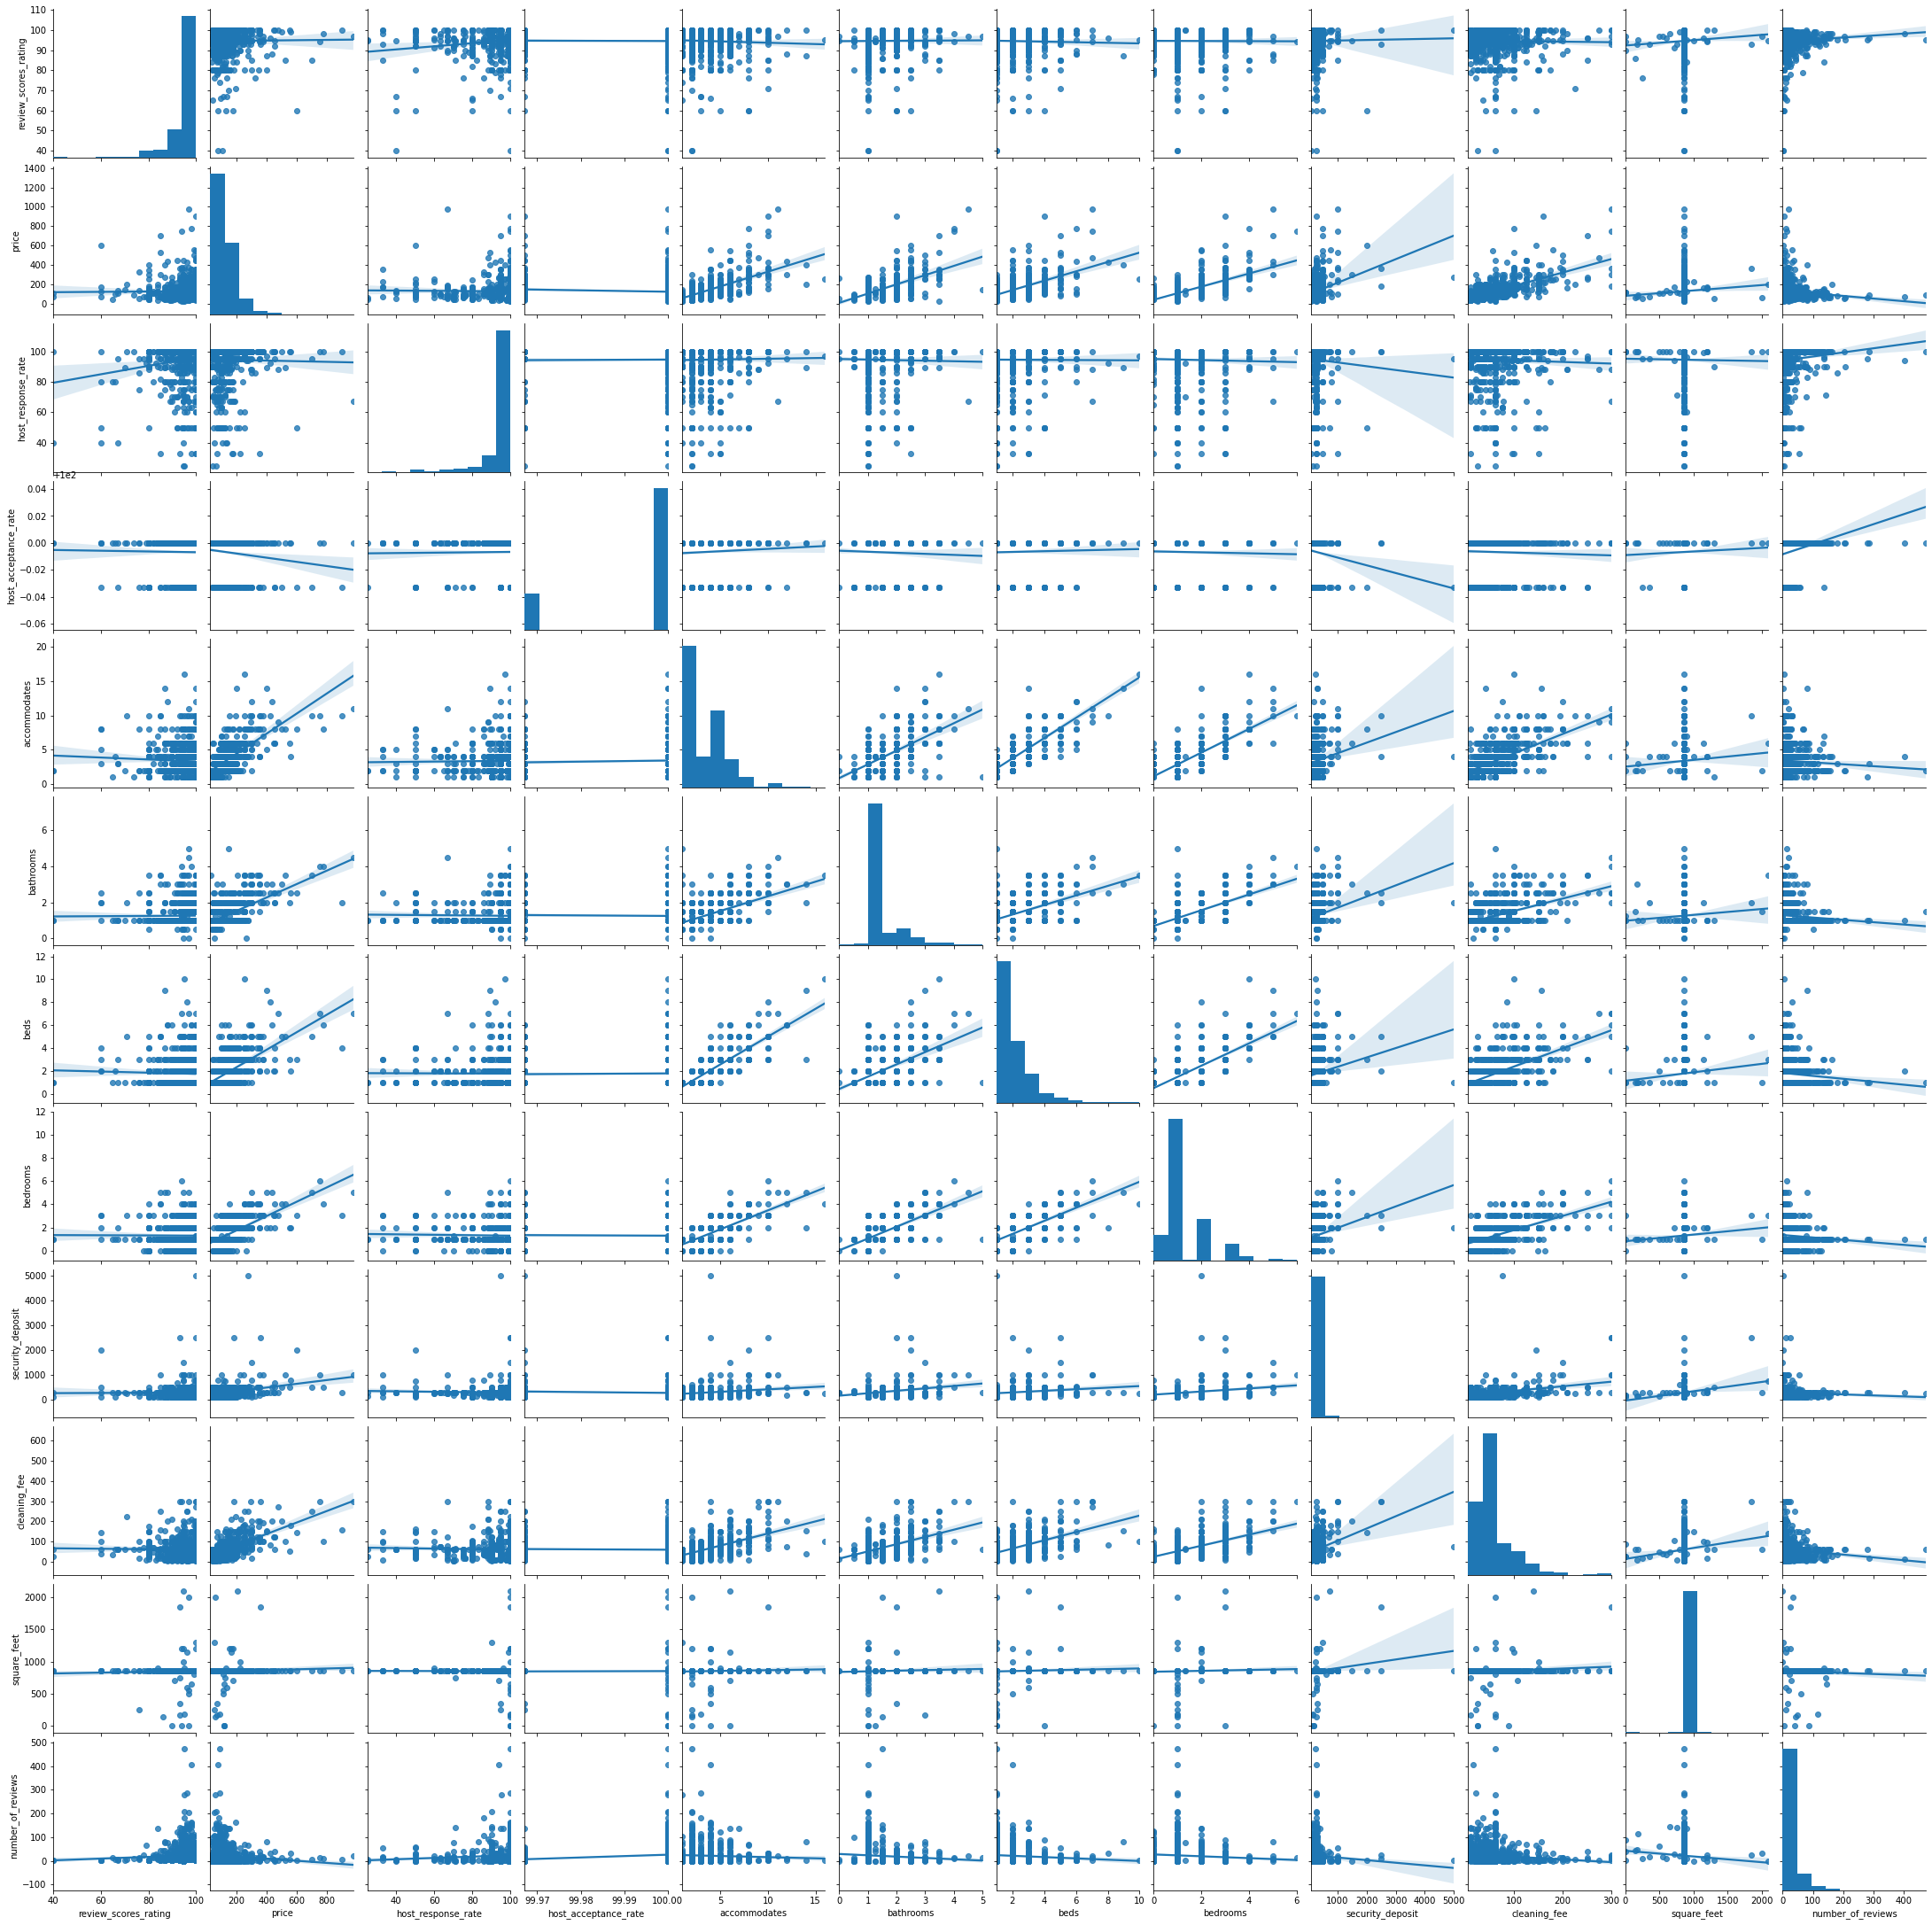

In [56]:
# Seattle
g = sns.pairplot(Seattle_listings_df.sample(1000, random_state=40), \
                 vars=['review_scores_rating', 'price', 'host_response_rate', 'host_acceptance_rate', 'accommodates', 'bathrooms', \
                       'beds', 'bedrooms', 'security_deposit', 'cleaning_fee', 'square_feet', \
                      'number_of_reviews'],kind="reg")

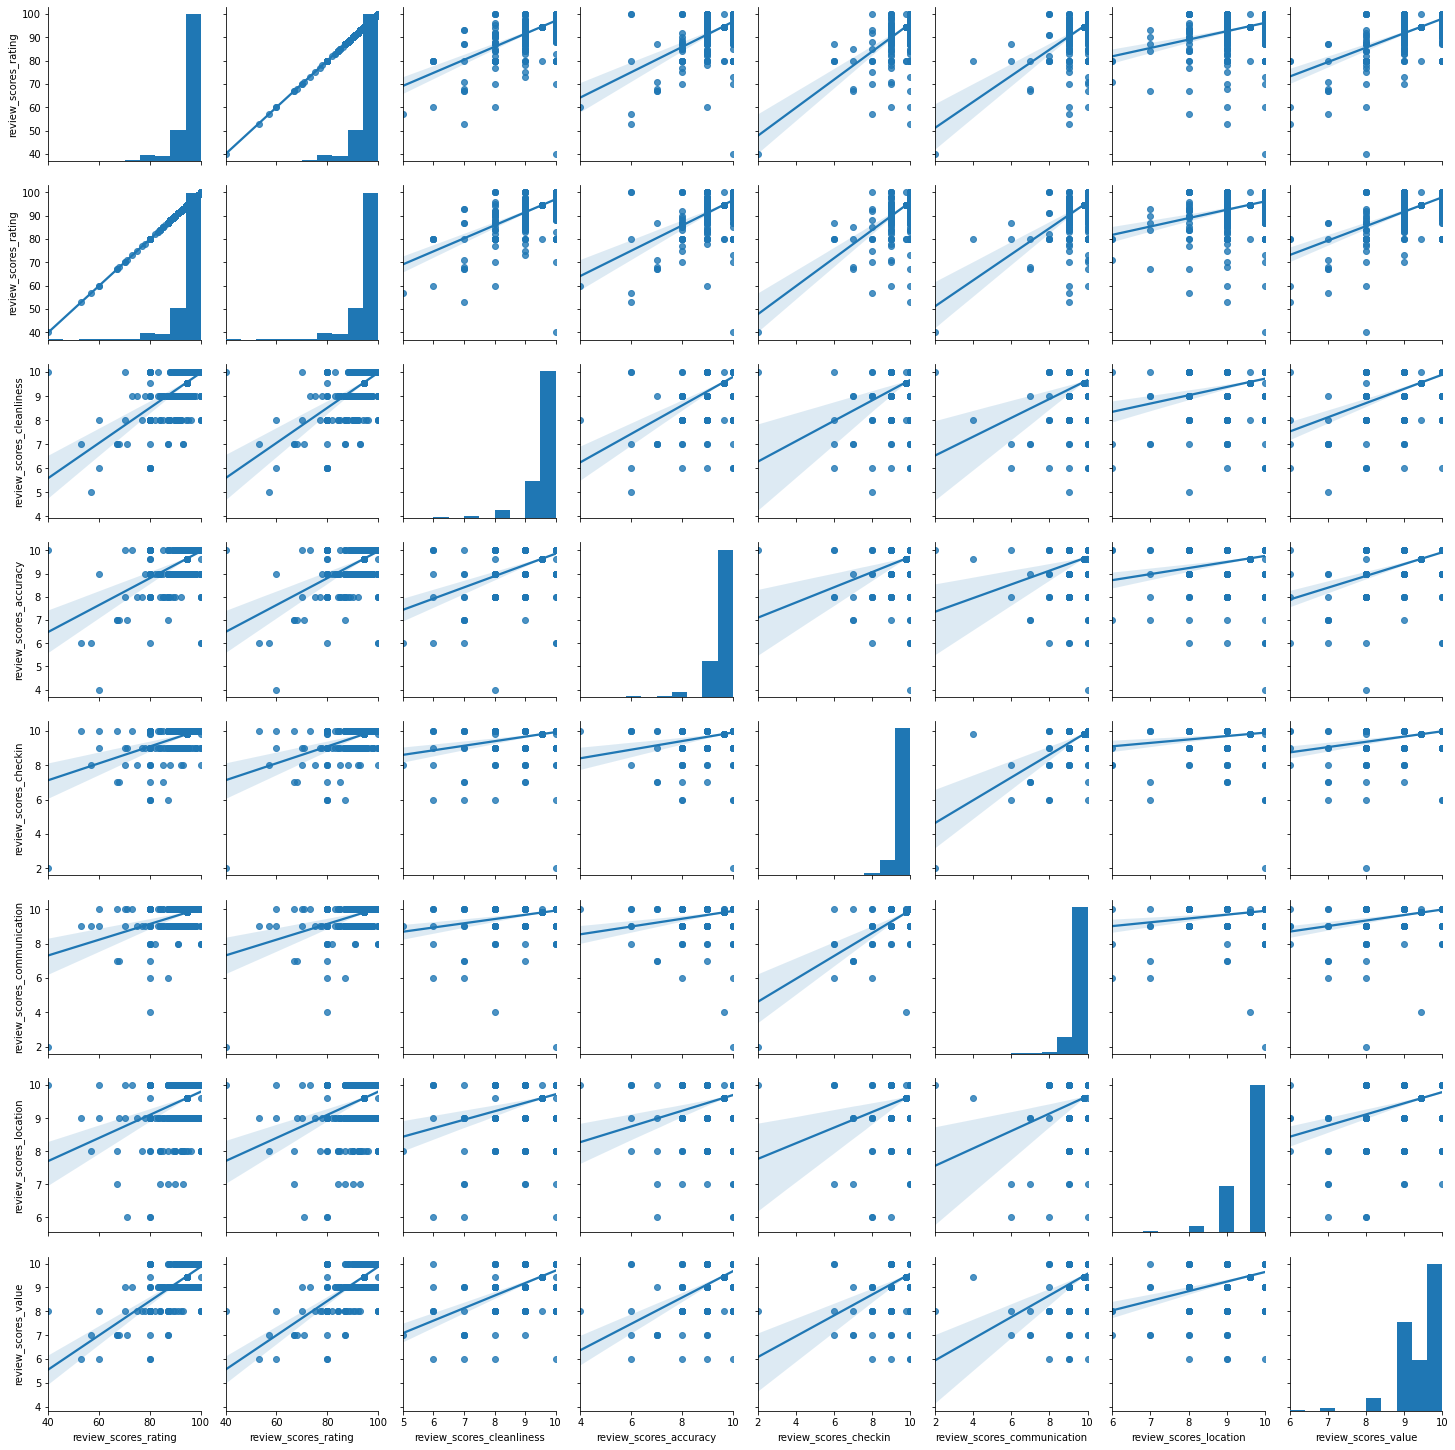

In [57]:
# Seattle
g = sns.pairplot(Seattle_listings_df.sample(1000, random_state=42), \
                 vars=['review_scores_rating', 'review_scores_rating', 'review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_checkin', \
                       'review_scores_communication', 'review_scores_location', 'review_scores_value'] \
                       ,kind="reg")

##### Prediction

Let us see if we do a better job predicting the review_scores_rating. Initially, we will not drop the rest of revies to see how well it does. Afterwards, we will delete them and see how it performs.

In [58]:
# Linear model
# BOSTON
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = \
clean_fit_linear_mod(Boston_listings_df, 'review_scores_rating')
print('Boston test score', test_score, 'train score', train_score)

# SEATTL
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = \
clean_fit_linear_mod(Seattle_listings_df, 'review_scores_rating')
print('Seattle test score', test_score, 'train score', train_score)

Boston test score -5.100940826139777e+27 train score 0.8029755513777721
Seattle test score -7.300631404251152e+27 train score 0.6804347503310695


We see that in the training it does much better than when predicting price, but in the testing once again it does terrible. Given this terrible performance, it is not even worth the time to delete key fields like the rest of reviews, as it can only perform worst. 

In [59]:
# Polynomial model
# BOSTON
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = \
clean_fit_polynomial_mod(Boston_listings_df, 'price')
print('Boston test score', test_score, 'train score', train_score)

# SEATTLE
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = \
clean_fit_polynomial_mod(Seattle_listings_df, 'price')
print('Seattle test score', test_score, 'train score', train_score)

Boston test score -4503595.560130922 train score 0.8568133856505753
Seattle test score -530615261353.864 train score 0.9884356355705533


There is also not much to say about the terrible performance.

My conclusion with respect to prediction is that we need more data to have accurate results.